In [1]:
from huggingface_hub import hf_hub_download
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "Elriggs/pythia-70m-deduped"

# The layer around which we want to interpret by looking at the last layer
layer_focus = 1
assert layer_focus > 0

In [2]:
def load_autoencoder(layer: int):
	ae_download_location_main = hf_hub_download(repo_id=model_id, filename=f"tied_residual_l{layer_focus}_r6/_63/learned_dicts.pt")
	all_autoencoders = torch.load(ae_download_location_main)
	all_l1s = [hyperparams["l1_alpha"] for autoencoder, hyperparams in all_autoencoders]
	# TODO: choose best one???
	print(all_l1s)
	auto_num = 5
	autoencoder, hyperparams = all_autoencoders[auto_num]
	# You want a hyperparam around 1e-3. Higher is less features/datapoint (at the cost of reconstruction error); lower is more features/datapoint (at the cost of polysemanticity)
	autoencoder.to_device(device)
	print(hyperparams)
	return autoencoder, hyperparams

autoencoder_main, hyperparams_main = load_autoencoder(layer_focus)
autoencoder_prior, hyperparams_prior = load_autoencoder(layer_focus - 1)

[0.0, 9.999999747378752e-05, 0.00019306977628730237, 0.000372759357560426, 0.0007196856895461679, 0.0013894954463467002, 0.0026826958637684584, 0.005179474595934153, 0.009999999776482582]
{'dict_size': 3072, 'l1_alpha': 0.0013894954463467002}
[0.0, 9.999999747378752e-05, 0.00019306977628730237, 0.000372759357560426, 0.0007196856895461679, 0.0013894954463467002, 0.0026826958637684584, 0.005179474595934153, 0.009999999776482582]
{'dict_size': 3072, 'l1_alpha': 0.0013894954463467002}


In [3]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from transformer_lens import HookedTransformer
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"

model = HookedTransformer.from_pretrained(model_name, device=device)

def get_cache_name_neurons(layer: int):
    if setting == "residual":
        cache_name = f"blocks.{layer}.hook_resid_post"
        neurons = model.cfg.d_model
    elif setting == "mlp":
        cache_name = f"blocks.{layer}.mlp.hook_post"
        neurons = model.cfg.d_mlp
    elif setting == "attention":
        cache_name = f"blocks.{layer}.hook_attn_out"
        neurons = model.cfg.d_model
    elif setting == "mlp_out":
        cache_name = f"blocks.{layer}.hook_mlp_out"
        neurons = model.cfg.d_model
    else:
        raise NotImplementedError
    return cache_name, neurons

cache_name, neurons  = get_cache_name_neurons(layer_focus)
cache_name_prior, _  = get_cache_name_neurons(layer_focus - 1)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [5]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
# dataset_name = "NeelNanda/pile-10k"
# dataset_name = "JeanKaddour/minipile"
token_amount= 40
#TODO: change train[:1000] to train if you want whole dataset
# 100_000 datasets
# I think that we want to use the full 1_000_000 at some point...
dataset = load_dataset(dataset_name, split="train[:10000]").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)
# TODO: we can maybe make this faster for the larger dataset?

Found cached dataset parquet (/home/lev/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /home/lev/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-b0ed20a195071411.arrow
Loading cached processed dataset at /home/lev/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-ae4a1900efe67bdd.arrow
Loading cached processed dataset at /home/lev/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5bfe56a6aa369248.arrow


# Get Dictionary Activations

In [6]:
# TODO: in chunks...
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from datasets import DatasetDict
from tqdm.auto import tqdm
from einops import rearrange
import math

# MAX_CHUNK_SIZE = 1_000

# TODO: move to a separate file or something
def get_activations(autoencoder, f_name):
    num_features, d_model = autoencoder.encoder.shape
    datapoints = dataset.num_rows
    dictionary_activations_final = np.memmap(f'{f_name}.mymemmap', dtype='float32', mode='w+', shape=(datapoints * token_amount, num_features))
    # neuron_activations = torch.zeros((datapoints*token_amount, d_model))
    neuron_activations = np.memmap(f'neur{f_name}.mymemmap', dtype='float32', mode='w+', shape=(datapoints * token_amount, d_model))
    batch_size = 32
    # dictionary_activations = np.zeros((datapoints*token_amount, num_features))
    smaller_auto_encoder = autoencoder
    smaller_auto_encoder.to_device(device)

    # print("Creating data dict")
    # d = DatasetDict(Dataset(dataset[ind_low:ind_max]))
    # print("Got data dict")
    # with torch.no_grad(), d.formatted_as("pt"):
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            # print(batch)
            _, cache = model.run_with_cache(batch.to(device))
            batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
            neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
            batched_dictionary_activations = smaller_auto_encoder.encode(batched_neuron_activations)
            dictionary_activations_final[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu().numpy()
    del neuron_activations
        # dictionary_activations_final[ind_low:ind_max] = dictionary_activations
        # chunks.append(dictionary_activations)
    return dictionary_activations_final

dict_activations_main = get_activations(autoencoder_main, "main")
dict_activations_prior = get_activations(autoencoder_prior, "prior")
# TODO: I think that we may want to save this to disk for the future


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

#### Find the the minimum size necessary for an activation to be considered a word

In [7]:
nonzeroind = np.nonzero(dict_activations_main)
nonzero_sort = np.sort(dict_activations_main[np.nonzero(dict_activations_main)])

In [8]:
print(nonzero_sort[:200].tolist())

[1.1920928955078125e-07, 1.7881393432617188e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 2.384185791015625e-07, 3.5762786865234375e-07, 3.5762786865234375e-07, 3.5762786865234375e-07, 4.76837158203125e-07, 4.76837158203125e-07, 4.76837158203125e-07, 4.76837158203125e-07, 4.76837158203125e-07, 4.76837158203125e-07, 5.960464477539062e-07, 5.960464477539062e-07, 5.960464477539062e-07, 5.960464477539062e-07, 5.960464477539062e-07, 6.556510925292969e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.748603820800781e-07, 8.344650268554688e-07, 8.344650268554688e-07, 9.5367431640625e-07, 9.5367431640625e-07, 9.5367431640625e-07, 9.5367431640625e-07, 1.0132789611816406e-06, 1.0728836059570312e-06, 1.1920928955078125e-06, 1.19209289550781

## Build the 2-depth Concept Lattice
<!-- TODO: general depth -->

In [38]:
datapoints = dataset.num_rows
num_features_prior, _ = autoencoder_prior.encoder.shape
num_features_main, _ = autoencoder_main.encoder.shape

graph = np.memmap(f'graph.mymemmap', dtype='float32', mode='w+', shape=(num_features_main, num_features_prior))

for i in range(num_features_main):
		graph[i,:] = np.zeros(num_features_prior)

In [39]:
eps = 0.001

for i in range(datapoints):
	d_prior = dict_activations_prior[i]
	d_main = dict_activations_main[i]
	for main_feat in range(num_features_main):
		if d_main[main_feat] > eps:
			graph[main_feat] += (d_prior > eps) * d_prior

In [40]:
# TODO: hmmm. The `graph` is data-set dependent so we want to renormalize
graph = graph / graph.sum(axis=1, keepdims=True)

/tmp/ipykernel_84821/4134241563.py:2: RuntimeWarning: invalid value encountered in divide
  graph = graph / graph.sum(axis=1, keepdims=True)


In [55]:
epsCutoff = 0.005

graphCutoff = (graph >= epsCutoff) * graph

Feature has 27 connections


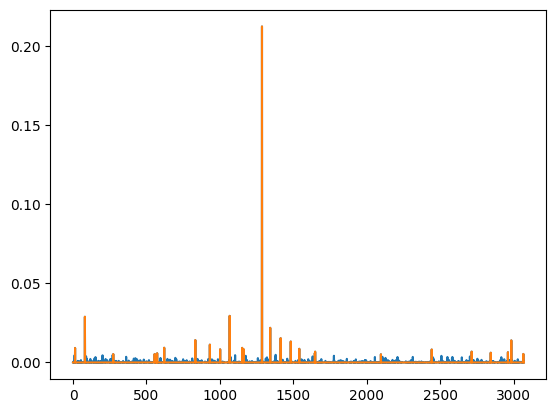

In [103]:
# Check how "sparse" the graph is
import matplotlib.pyplot as plt

# 10 has **a bunch** of connections
# feature = 10

feature = 81

max_features = np.argsort(graphCutoff[feature])[::-1]
# print(max_features[:10].tolist(), graphCutoff[feature][max_features][:10].tolist())
print(f"Feature has {graphCutoff[feature].nonzero()[0].shape[-1]} connections")

plt.plot(graph[feature])
plt.plot(graphCutoff[feature])

In [63]:
for i in range(num_features_main):
	if graphCutoff[i].sum() == 0:
		if graph[i].sum() > 0:
			print(f"Feature {i} has no connections in cutoff but {graph[i].sum()} connections in non-cutoff")
		else:
			print(f"Feature {i} has no connections at all!")

## Some Graphing

[1287 1002 1067 2108  621] [0.18581152 0.03723465 0.02946642 0.01971821 0.01373565]
[1287 1483  621 2221 1321] [0.19354156 0.02738515 0.02071562 0.01326988 0.01270611]
[1287 1483 1321 2137 2342] [0.12719868 0.06569866 0.04363534 0.03286748 0.02949935]
[1287 2340 1258 2985  466] [0.198088   0.04752313 0.03664751 0.03497132 0.03391978]
[1287 1483 1067 1002  833] [0.18435685 0.01751497 0.01628463 0.01623563 0.01329688]
[1287 1002 1483 1067  621] [0.17206901 0.03029695 0.02186104 0.01336683 0.01290123]
[1287 1002 1067 1483  621] [0.16477242 0.02484675 0.01977484 0.01930455 0.01669323]
[1287 1002 1483 1067  833] [0.1551748  0.05102627 0.02461586 0.02439294 0.01441632]
[1287  621 1483 2137 1321] [0.13751653 0.02240434 0.02186633 0.01272462 0.01219103]
[1287 1389 3067 1002  802] [0.18975423 0.02410969 0.01802451 0.01633795 0.01460226]


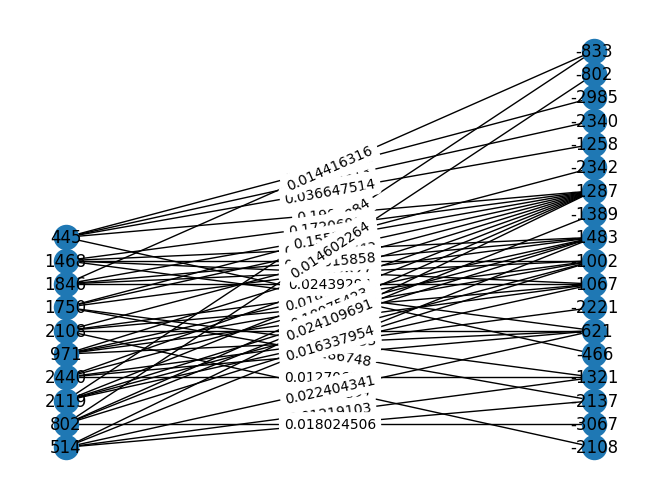

In [105]:
import matplotlib.pyplot as plt
import networkx as nx


GRAPH_SIZE_MAIN = 10
main_feats = np.random.choice(num_features_main, GRAPH_SIZE_MAIN, replace=False)
prior_feats = np.nonzero(graphCutoff[main_feats])[1]

randomGraphProjection = graphCutoff[main_feats][:,prior_feats]


# Create a new bipartite graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
# nodes_u = set((prior_feats * -1).tolist())  # Set of nodes V
nodes_v = main_feats.tolist() # Set of nodes U
# B.add_nodes_from(nodes_u, bipartite=0)  # Label one set of nodes 0
B.add_nodes_from(nodes_v, bipartite=1)  # Label the other set of nodes 1

edges = []

for main in main_feats:
	has_edge = False
	# nonzerod = graphCutoff[main].nonzero()[0]
	D_NEIGHBORS = 5
	args = np.argsort(graphCutoff[main])[::-1][:5]
	print(args, graphCutoff[main][args])
	for prior in args:
		if graphCutoff[main][prior] > 0:
			edges.append((prior * -1, main, graphCutoff[main][prior]))
			has_edge = True
	# for j in range(prior_feats.shape[-1]):
	# 	if randomGraphProjection[i,j] > 0:
	# 		print("Adding edge")
	# 		edges.append((prior_feats[j], main_feats[i], randomGraphProjection[i,j]))
	# 		has_edge = True
	if not has_edge:
		print("NO EDGE FOR FEATURE", i, main_feats[i])
# Add edges with weights
B.add_weighted_edges_from(edges)

# Separate by group
l, r = nx.bipartite.sets(B)
pos = {}

# Update position for node from each group
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

# Draw the graph
nx.draw(B, pos, with_labels=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(B, 'weight')
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels)

plt.show()


# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [13]:
dict_activations_prior.shape

(394480, 3072)

In [14]:
from circuitsvis.activations import text_neuron_activations
import torch
import numpy as np
from einops import rearrange

# Get the activations for the best dict features
def get_feature_datapoints_with_idx(feature_index, dictionary_activations, tokenizer, token_amount, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = np.argsort(best_feature_activations)[:k]
        # found_indices = np.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        # min_value = torch.min(best_feature_activations)
        min_value = np.min(best_feature_activations)
        max_value = np.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = np.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        # TODO: hmm
        # np bucketize?
        # bins = torch.bucketize(best_feature_activations, bin_boundaries)
        bins = np.digitize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in np.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = np.array(np.nonzero(bins == bin_idx)).squeeze(axis=0)
            # print(bin_indices.shape)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = np.flip(np.array(sampled_indices), axis=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    num_datapoints = int(dictionary_activations.shape[0]/token_amount)
    datapoint_indices =[np.unravel_index(i, (num_datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list, found_indices

In [15]:
from interp_utils import *
# Can sort by MMCS w/ the larger dictionary
# indexed_feature = 13
# best_feature = int(max_indices[indexed_feature])
# Or just random index 
feature_idx = 1067
feature_idx = 200

text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(feature_idx, dict_activations_prior, model.tokenizer, token_amount, dataset, setting="uniform")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(feature_idx, dict_activations_prior, model.tokenizer, token_amount, dataset, setting="max")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
# visualize_text(full_text, best_feature, model, autoencoder, layer)
print("Sampled Index", sampled_indices)
visualize_text(text_list, feature_idx, model, autoencoder_prior, layer_focus - 1)

Sampled Index [342023 170568  39568 130015  43077 310356 387538  91576   2923  80785
   1777]


In [20]:
feature_idx = 1380

text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(feature_idx, dict_activations_main, model.tokenizer, token_amount, dataset, setting="uniform", k=100)
visualize_text(text_list, feature_idx, model, autoencoder_prior, layer_focus)

## Find the **downstream** feature in the next layer that is most activated by random subset of this feature

In [17]:
prior_feature_idx = 13
k = 200

text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(prior_feature_idx, dict_activations_prior, model.tokenizer, token_amount, dataset, setting="max", k=k)
# text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(prior_feature_idx, dict_activations_prior, model.tokenizer, token_amount, dataset, setting="max", k=k)

# print("Sampled Index", sampled_indices)
# dict_activations_prior.shape, dict_activations_main.shape
TOP_FEATURES = 20
# We do not need absolute value as I think that everything is positive b/c ReLU
summed = dict_activations_main[sampled_indices].sum(axis=0)
print(summed.argmax())
main_features = summed.argsort()[::-1][:TOP_FEATURES]
main_features

1287


array([1287, 1321,  621, 1483,  833, 1866, 1002, 1067, 3019, 1104,  556,
       1414,   14,  450, 1649,  458, 2443, 1368, 2703, 1844])

In [18]:
visualize_text(text_list, feature_idx, model, autoencoder_prior, layer_focus - 1)

In [19]:
feature_idx = main_features[3].item()
 
k = 20
text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(feature_idx, dict_activations_main, model.tokenizer, token_amount, dataset, setting="uniform", k=k)
visualize_text(text_list, feature_idx, model, autoencoder_prior, layer_focus)